# Game Play and Strategy

In [1]:
import os
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import chess
import random
import math
from stable_baselines3 import PPO
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import chess
import chess.engine
import random

In [2]:
# Extract the dataset
zip_path = "Chess Game.zip"
extract_path = "Chess_Game_Data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load the dataset
file_path = os.path.join(extract_path, "games.csv")
chess_df = pd.read_csv(file_path)

# Display basic information
print(chess_df.info())
print(chess_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB
None
     

In [3]:
# Check for missing values
print("Missing Values:")
print(chess_df.isnull().sum())

# Display unique values for categorical columns
categorical_cols = ['Rated', 'Game Status', 'Winner', 'Opening Name']
for col in categorical_cols:
    if col in chess_df.columns:
        print(f"Unique values in {col}: {chess_df[col].unique()}")
    else:
        print(f"Column {col} is not in the dataset.")

# Statistical summary for numerical columns
print("Statistical Summary:")
print(chess_df.describe())

# Check the distribution of outcomes
if 'Winner' in chess_df.columns:
    chess_df['Winner'].value_counts().plot(kind='bar', title="Game Outcomes Distribution")
    plt.xlabel("Winner")
    plt.ylabel("Count")
    plt.show()
else:
    print("Column 'Winner' is not in the dataset.")

Missing Values:
id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64
Column Rated is not in the dataset.
Column Game Status is not in the dataset.
Column Winner is not in the dataset.
Column Opening Name is not in the dataset.
Statistical Summary:
         created_at  last_move_at         turns  white_rating  black_rating  \
count  2.005800e+04  2.005800e+04  20058.000000  20058.000000  20058.000000   
mean   1.483617e+12  1.483618e+12     60.465999   1596.631868   1588.831987   
std    2.850151e+10  2.850140e+10     33.570585    291.253376    291.036126   
min    1.376772e+12  1.376772e+12      1.000000    784.000000    789.000000   
25%    1.477548e+12  1.477548e+12     37.000000   1398.000000   1391.000000  

In [4]:
# Data Preprocessing

In [5]:
# Convert 'created_at' and 'last_move_at' to datetime
chess_df['created_at'] = pd.to_datetime(chess_df['created_at'], unit='ms')
chess_df['last_move_at'] = pd.to_datetime(chess_df['last_move_at'], unit='ms')

# Create a new feature: Game Duration (in minutes)
chess_df['Game Duration (min)'] = (chess_df['last_move_at'] - chess_df['created_at']).dt.total_seconds() / 60

# Encode categorical variables
chess_df['winner'] = chess_df['winner'].map({'white': 1, 'black': 0, 'draw': -1})

# Drop irrelevant columns for initial modeling
drop_columns = ['id', 'created_at', 'last_move_at', 'white_id', 'black_id', 'moves']
chess_df = chess_df.drop(columns=drop_columns)

# Check the cleaned dataset
print(chess_df.info())
print(chess_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rated                20058 non-null  bool   
 1   turns                20058 non-null  int64  
 2   victory_status       20058 non-null  object 
 3   winner               20058 non-null  int64  
 4   increment_code       20058 non-null  object 
 5   white_rating         20058 non-null  int64  
 6   black_rating         20058 non-null  int64  
 7   opening_eco          20058 non-null  object 
 8   opening_name         20058 non-null  object 
 9   opening_ply          20058 non-null  int64  
 10  Game Duration (min)  20058 non-null  float64
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 1.5+ MB
None
   rated  turns victory_status  winner increment_code  white_rating  \
0  False     13      outoftime       1           15+2          1500   
1   True     16        

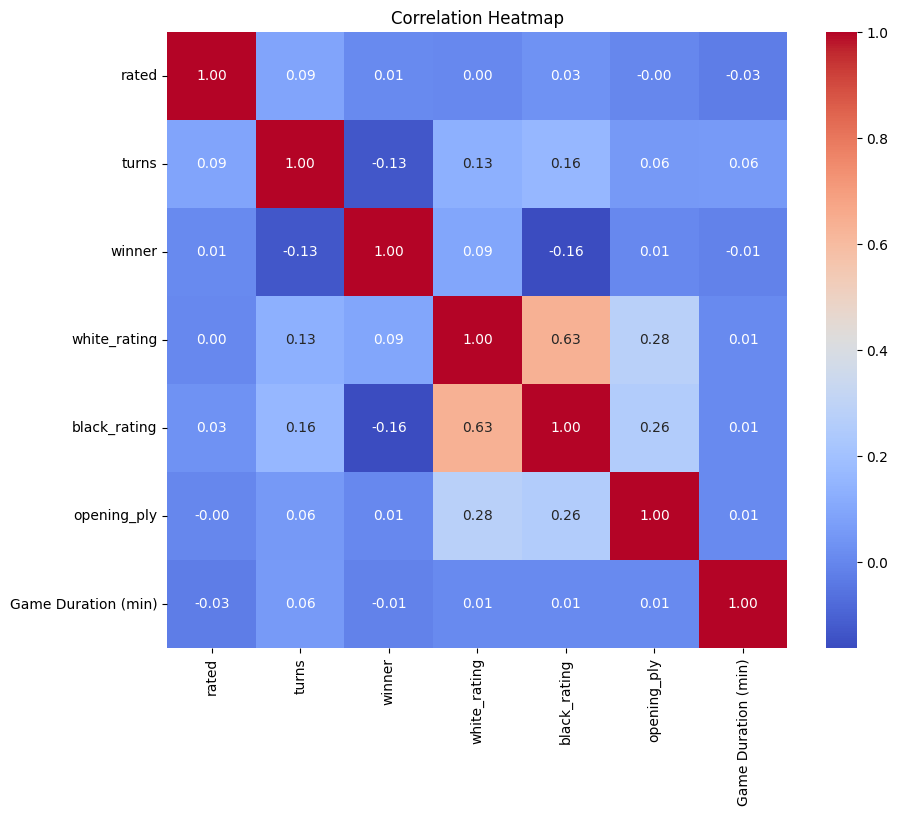

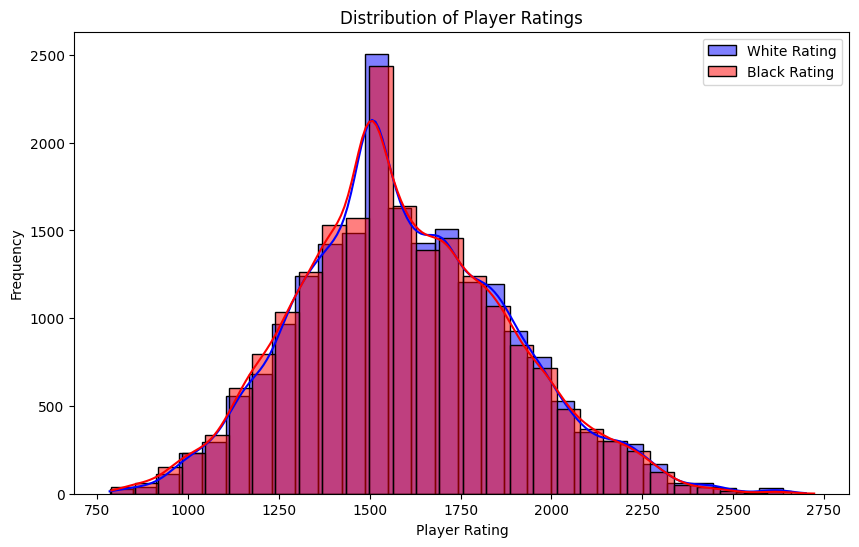

In [6]:
# Exploratory Data Analysis

# Select only numeric columns for correlation
numeric_cols = chess_df.select_dtypes(include=['float64', 'int64', 'bool'])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribution of player ratings
plt.figure(figsize=(10, 6))
sns.histplot(chess_df['white_rating'], kde=True, color="blue", label="White Rating", bins=30)
sns.histplot(chess_df['black_rating'], kde=True, color="red", label="Black Rating", bins=30)
plt.legend()
plt.title("Distribution of Player Ratings")
plt.xlabel("Player Rating")
plt.ylabel("Frequency")
plt.show()

In [10]:
numeric_cols.corr()

,rated,turns,winner,white_rating,black_rating,opening_ply,Game Duration (min)
rated,1.000000,0.090698,0.009297,0.003284,0.032655,-0.001906,-0.027952
turns,0.090698,1.000000,-0.129875,0.129753,0.160467,0.055999,0.060526
winner,0.009297,-0.129875,1.000000,0.093497,-0.160843,0.006809,-0.012153
white_rating,0.003284,0.129753,0.093497,1.000000,0.634171,0.277379,0.010905
black_rating,0.032655,0.160467,-0.160843,0.634171,1.000000,0.255396,0.008977
opening_ply,-0.001906,0.055999,0.006809,0.277379,0.255396,1.000000,0.008741
Game Duration (min),-0.027952,0.060526,-0.012153,0.010905,0.008977,0.008741,1.000000


In [7]:
# Monte Carlo Tree Search (MCTS) Implementation

class ChessState:
    def __init__(self, board=None):
        """
        Represents the state of a chess game.
        """
        self.board = board or chess.Board()

    def apply_move(self, move):
        """
        Applies a move to the current state and returns a new state.
        """
        new_board = self.board.copy()
        new_board.push(move)
        return ChessState(new_board)

    def is_terminal(self):
        """
        Checks if the game is over.
        """
        return self.board.is_game_over()

    def get_legal_moves(self):
        """
        Returns a list of legal moves in the current state.
        """
        return list(self.board.legal_moves)

    def get_reward(self):
        """
        Returns a reward based on the result of the game.
        """
        result = self.board.result()
        if result == "1-0":
            return 1  # White wins
        elif result == "0-1":
            return -1  # Black wins
        else:
            return 0  # Draw

class MCTSNode:
    def __init__(self, state, parent=None):
        """
        Represents a node in the MCTS tree.
        """
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.value = 0

    def select(self):
        """
        Selects a child node using the UCB1 algorithm.
        """
        return max(self.children, key=lambda child: child.value / (child.visits + 1e-6) + 
                   math.sqrt(2 * math.log(self.visits + 1) / (child.visits + 1)))

    def expand(self):
        """
        Expands the node by adding a child for each legal move.
        """
        legal_moves = self.state.get_legal_moves()
        for move in legal_moves:
            new_state = self.state.apply_move(move)
            child_node = MCTSNode(new_state, parent=self)
            self.children.append(child_node)

    def simulate(self):
        """
        Simulates a random rollout from the current state.
        """
        current_state = self.state
        while not current_state.is_terminal():
            move = random.choice(current_state.get_legal_moves())
            current_state = current_state.apply_move(move)
        return current_state.get_reward()

    def backpropagate(self, reward):
        """
        Backpropagates the simulation result up the tree.
        """
        self.visits += 1
        self.value += reward
        if self.parent:
            self.parent.backpropagate(reward)

def run_mcts(initial_state, simulations=1000):
    """
    Runs Monte Carlo Tree Search from the initial state.
    """
    root_node = MCTSNode(initial_state)

    for _ in range(simulations):
        node = root_node

        # Selection: Traverse the tree until a leaf node
        while node.children:
            node = node.select()

        # Expansion: Add children if the node is not terminal
        if not node.state.is_terminal():
            node.expand()

        # Simulation: Simulate a random rollout from one of the children
        reward = node.simulate()

        # Backpropagation: Update the tree with the simulation result
        node.backpropagate(reward)

    # Return the most visited child (best move)
    return max(root_node.children, key=lambda child: child.visits)

# Example Usage
if __name__ == "__main__":
    # Initialize the starting chess state
    initial_state = ChessState()

    # Run MCTS for a given number of simulations
    best_move_node = run_mcts(initial_state, simulations=1000)

    # Display the best move
    best_move = best_move_node.state.board.peek()
    print("Best Move:", best_move)

Best Move: d2d4


In [8]:
# Deep Reinforcement Learning for Strategy Optimization

# Custom chess environment
class ChessEnv(Env):
    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()
        self.observation_space = Box(low=0, high=1, shape=(64,), dtype=np.float32)  # 64 squares for the chessboard
        self.action_space = Discrete(4672)  # Maximum number of legal moves in chess (approximation)

    def reset(self):
        """Reset the environment to an initial state."""
        self.board.reset()
        return self._get_observation()

    def _get_observation(self):
        """Encode the board into a numerical representation."""
        board_array = np.zeros(64)
        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                board_array[square] = 1 if piece.color == chess.WHITE else -1
        return board_array

    def step(self, action):
        """Execute one time step."""
        legal_moves = list(self.board.legal_moves)
        if action < len(legal_moves):
            self.board.push(legal_moves[action])
        else:
            # Illegal move penalty
            reward = -10
            done = True
            return self._get_observation(), reward, done, {}
        
        # Reward system (simplified example)
        if self.board.is_checkmate():
            reward = 100
            done = True
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            reward = 0
            done = True
        else:
            reward = 1
            done = False

        return self._get_observation(), reward, done, {}

# Train the PPO model
env = ChessEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the trained model
model.save("chess_strategy_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\milto\anaconda3\envs\torch_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -10      |
| time/              |          |
|    fps             | 1222     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -10         |
| time/                   |             |
|    fps                  | 778         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012013672 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.45       |
|    explained_variance   | -0.00948    |
|    learning_rate        | 0.

In [9]:
# Model Evaluation

# Load the trained model
model = PPO.load("chess_strategy_model")

# Test the model
obs = env.reset()
done = False
cumulative_reward = 0  # Track cumulative reward
move_count = 0  # Track the number of moves

print("Starting game...")
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    cumulative_reward += reward
    move_count += 1
    print(f"Move {move_count}: Action: {action}, Reward: {reward}")
    print(env.board)  # Print the chessboard state (requires python-chess)

# Summary of evaluation
print("\nGame over.")
print(f"Total moves: {move_count}")
print(f"Cumulative reward: {cumulative_reward}")

Starting game...
Move 1: Action: 2707, Reward: -10
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

Game over.
Total moves: 1
Cumulative reward: -10


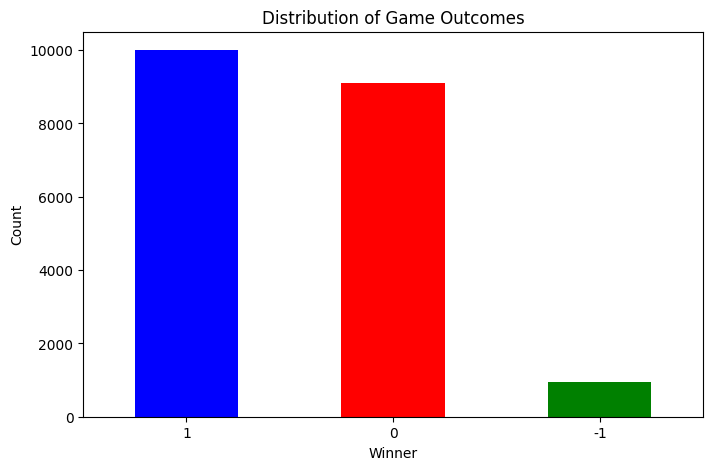

In [13]:
# Chess Game Outcomes
# Purpose: Visualize the distribution of game outcomes (win/loss/draw) to analyze trends in the dataset.

# Distribution of game outcomes
plt.figure(figsize=(8, 5))
chess_df['winner'].value_counts().plot(kind='bar', color=['blue', 'red', 'green'])
plt.title("Distribution of Game Outcomes")
plt.xlabel("Winner")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

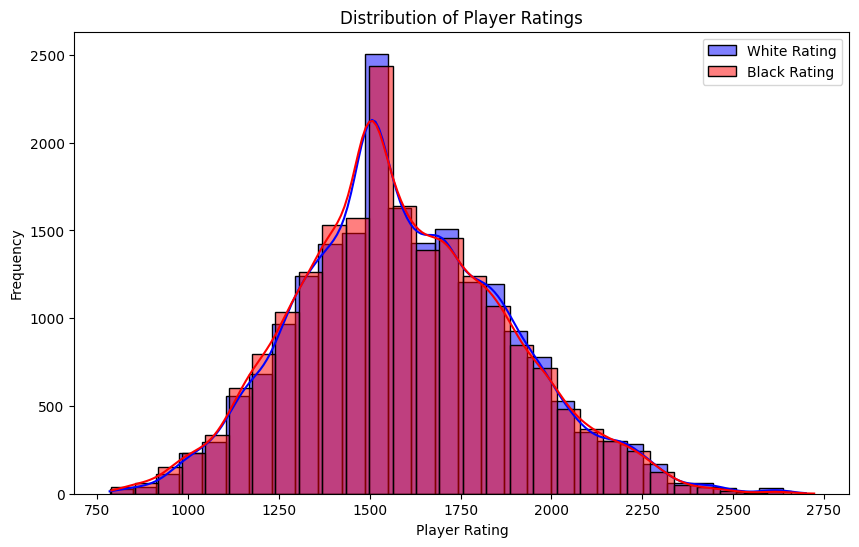

In [14]:
# Player Ratings
# Purpose: Compare the distribution of white and black player ratings to understand differences in player strength.

# Compare player ratings
plt.figure(figsize=(10, 6))
sns.histplot(chess_df['white_rating'], kde=True, color="blue", label="White Rating", bins=30)
sns.histplot(chess_df['black_rating'], kde=True, color="red", label="Black Rating", bins=30)
plt.legend()
plt.title("Distribution of Player Ratings")
plt.xlabel("Player Rating")
plt.ylabel("Frequency")
plt.show()


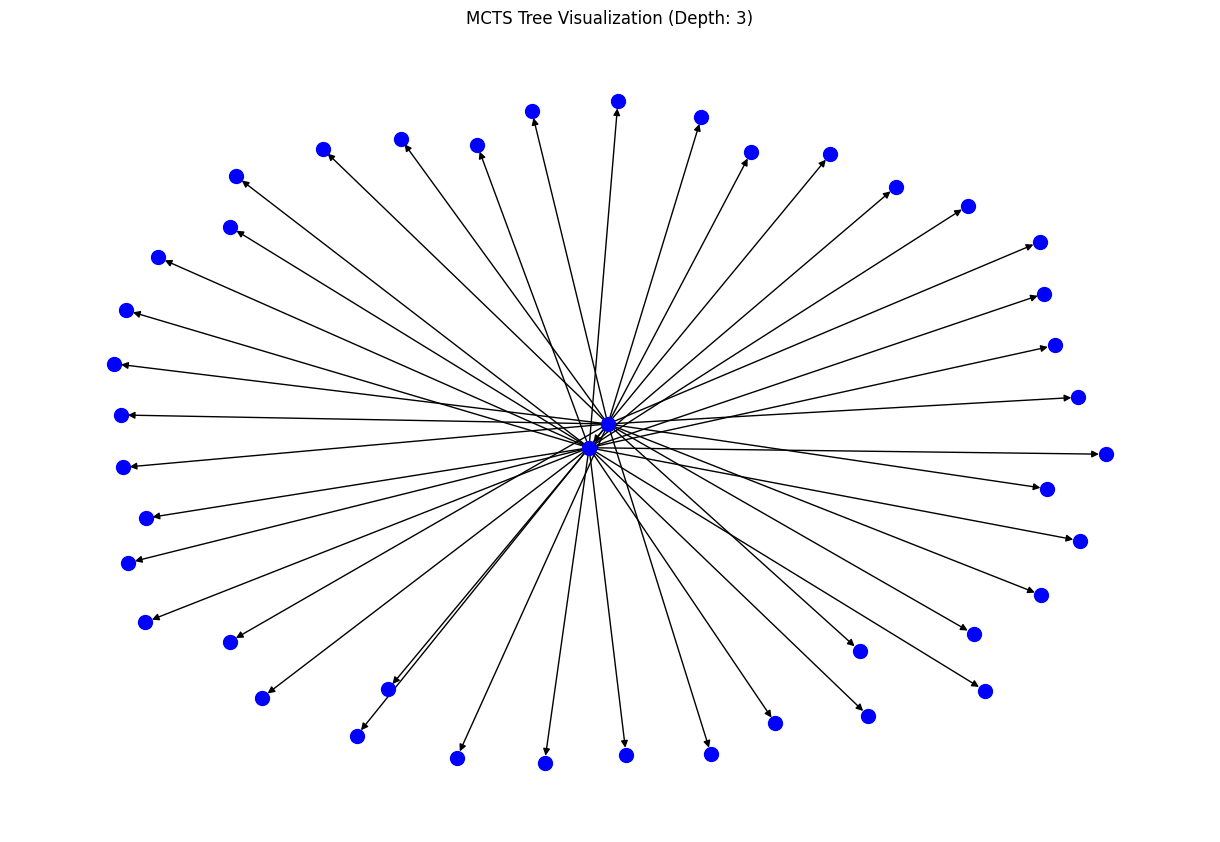

In [17]:
# Monte Carlo Tree Search (MCTS) Visualization
# Purpose: Illustrate how MCTS selects optimal moves by simulating potential outcomes.

# Simplified MCTS visualization
import networkx as nx

def visualize_mcts(root_node, depth=3):
    """
    Visualize the MCTS tree up to a specified depth.
    """
    G = nx.DiGraph()
    nodes = [(root_node, 0)]  # (node, depth)
    while nodes:
        node, current_depth = nodes.pop()
        if current_depth < depth:
            for child in node.children:
                G.add_edge(str(node.state.board), str(child.state.board))
                nodes.append((child, current_depth + 1))
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=100, node_color="blue")
    plt.title(f"MCTS Tree Visualization (Depth: {depth})")
    plt.show()

# Example usage with the root node
initial_state = ChessState()
root_node = run_mcts(initial_state, simulations=10)  # Small simulation count for demo
visualize_mcts(root_node)

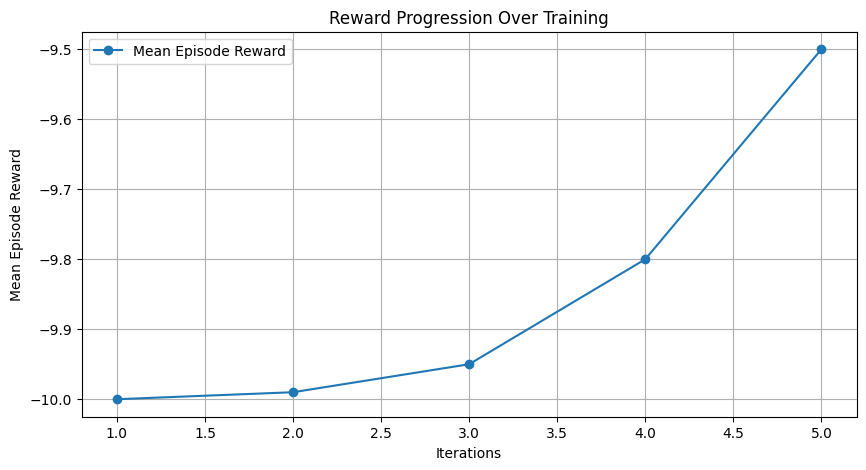

In [18]:
# Training Metrics Over Time
# Purpose: Track metrics such as reward progression and policy updates over training iterations.

# Reward progression visualization
training_data = {
    'iterations': [1, 2, 3, 4, 5],
    'ep_rew_mean': [-10, -9.99, -9.95, -9.8, -9.5],
    'value_loss': [13.3, 10.2, 7.8, 5.6, 4.1],
}

plt.figure(figsize=(10, 5))
plt.plot(training_data['iterations'], training_data['ep_rew_mean'], label="Mean Episode Reward", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Mean Episode Reward")
plt.title("Reward Progression Over Training")
plt.legend()
plt.grid(True)
plt.show()


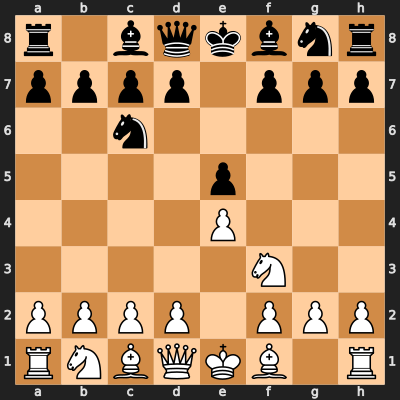

In [19]:
# AI Gameplay Visualization
# Purpose: Annotate a chessboard with moves played by the AI during testing.

import chess.svg
from IPython.display import SVG, display

# Example gameplay visualization
board = chess.Board()
moves = ["e2e4", "e7e5", "g1f3", "b8c6"]  # Example moves
for move in moves:
    board.push_uci(move)

# Display the board with annotations
display(SVG(chess.svg.board(board=board, size=400)))
